In [3]:
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as np
import numpy as onp
import matplotlib as mpl
import matplotlib.pyplot as plt
import visualutils as utils
import fsm_old as fsm
import fsm as nfsm
from functools import partial
from jax import jit,vmap
from loop import while_loop
from jax.flatten_util import ravel_pytree
from utils import compose, principal_value
import matplotlib.collections as mc
import importlib

ModuleNotFoundError: No module named 'fsm_old'

In [5]:
# trajectories : (ntimes=1000, nbirds=100, nvel=4)
# opacity      : (ntimes, nbirds, nstates)
# entropy      : (ntimes, nbirds, ncounts)
def readarray(fname):
    return np.array(onp.loadtxt(f"./data/{fname}", delimiter=","))
def recenter(R, r0):
    return R - r0
def rotate(R, θ0):
    Q = np.array([[np.cos(θ0), -np.sin(θ0)],
                 [np.sin(θ0), np.cos(θ0)]])
    return vmap(lambda r : Q.dot(r))(R)
def recenter_rotate(R, r0, θ0):
    return rotate(recenter(R,r0), θ0)

birds, nv, ns, nc = 100, 4, 40, 15

trj = readarray('trajectories.txt').reshape(-1,birds,nv)
opc = readarray('opacity.txt').reshape(-1,birds, ns)
ent = readarray('decision.txt').reshape(-1,birds,nc)
R  = trj[...,0:2]
θ  = trj[...,2]
V  = trj[...,3]

time  = 199
focus = np.array([29, 0, 1], dtype=int)
r0    = R[time, focus[0]]
θ0    = θ[time, focus[0]]

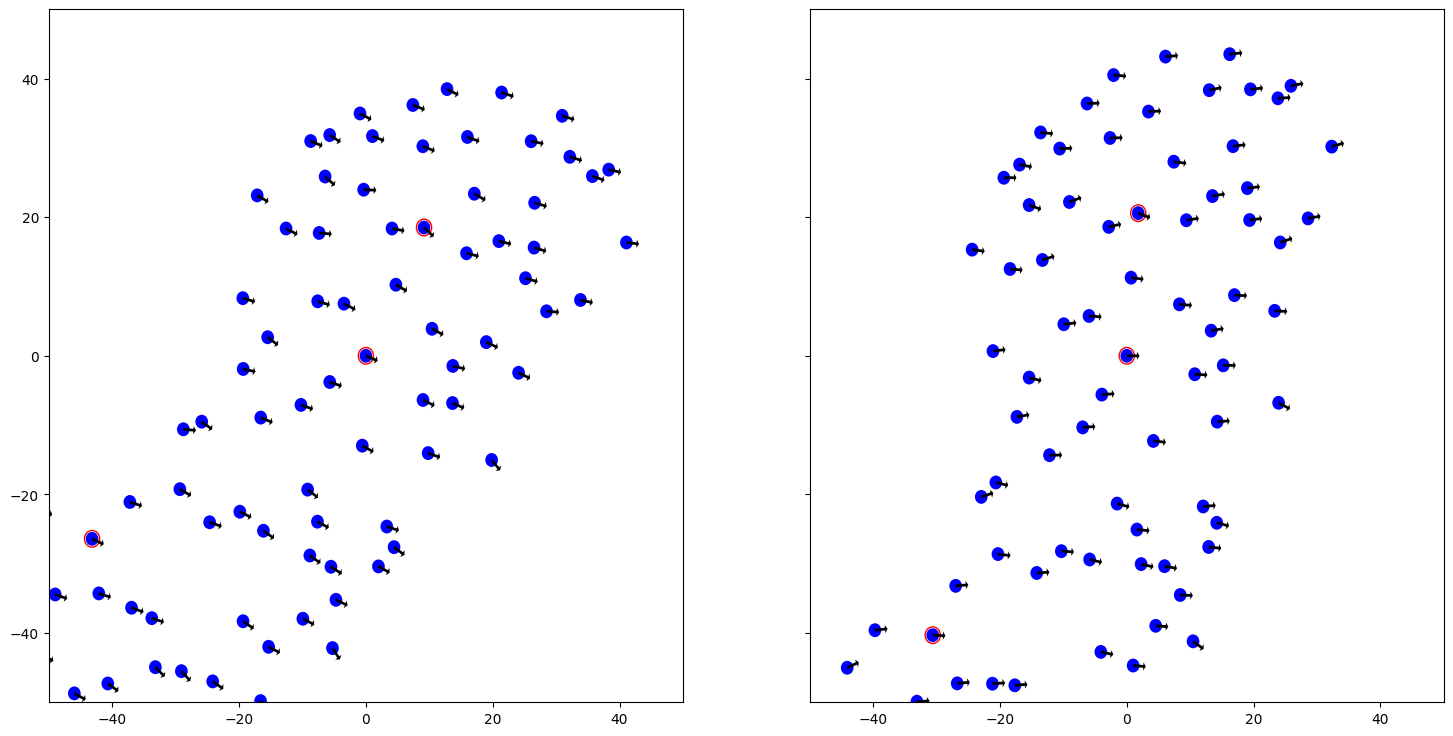

In [6]:
def drawstate(ax, R, θ=None, ids=None, width=1.0):
    # all birds
    patches = [plt.Circle(center, 1.0, edgecolor='None', aa=True) for center in R]
    col     = mc.PatchCollection(patches, facecolors='blue')
    ax.add_collection(col)

    # highlight selected birds
    if ids != None:
        patches = [plt.Circle(center, 1.2) for center in R[ids]]
        col     = mc.PatchCollection(patches, facecolors='None', edgecolors='red')
        ax.add_collection(col)
    
    # headings for all birds
    if θ != None:
        dirs    = vmap(lambda angle : 2.0*np.array([np.cos(angle), np.sin(angle)]))(θ)
        patches = [plt.Arrow(x,y,dx,dy, width=width) for (x,y),(dx,dy) in zip(R,dirs)]
        col     = mc.PatchCollection(patches, facecolors='k')
        ax.add_collection(col)
    
fig, [ax,bx] = plt.subplots(figsize=(18,9),ncols=2, sharex=True, sharey=True)
drawstate(ax, recenter(R[time], r0), θ[time], focus, width=2.0)
drawstate(bx, recenter_rotate(R[time], r0, -θ0), θ[time]-θ0, focus, width=2.0)
ax.set_xlim(-50,50)
ax.set_ylim(-50,50)
plt.show()

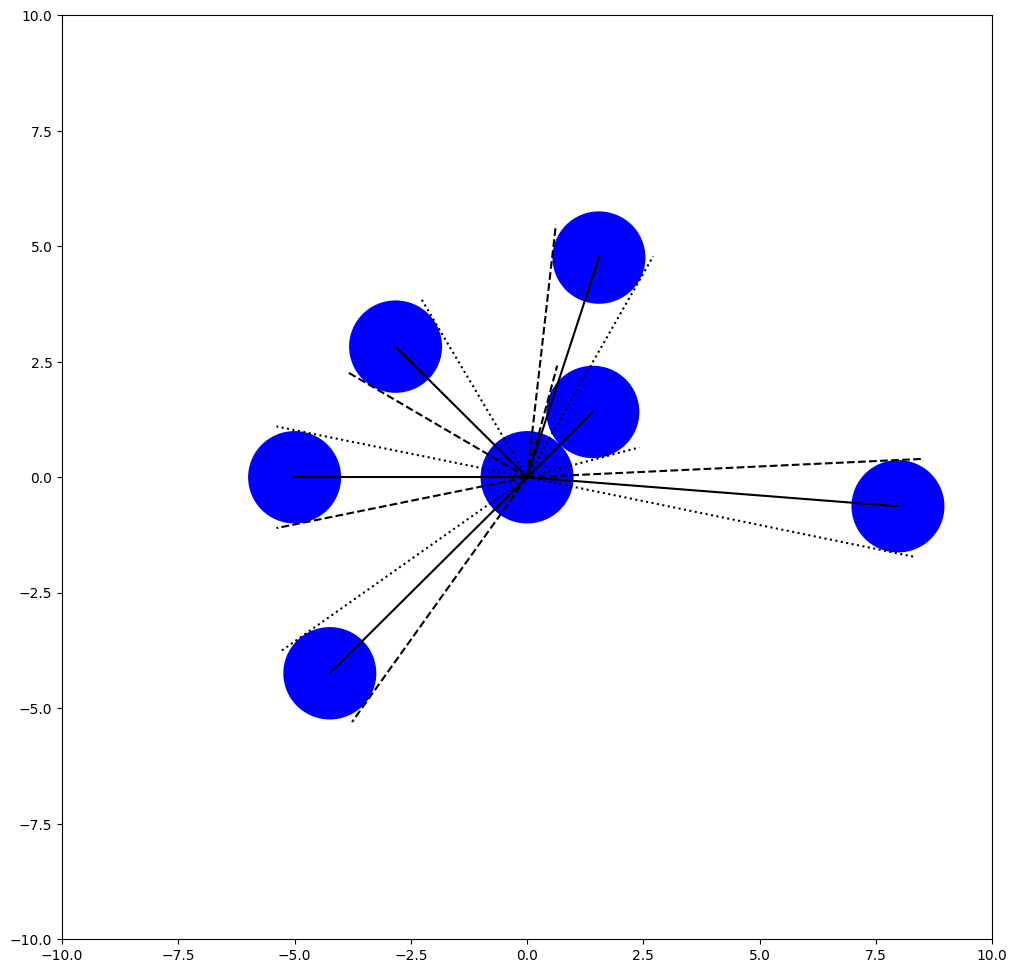

In [7]:
def testprojection(projection_function):
    angles = np.array([0., 1.6, 1., 3., 4., 5., 7.9])*np.pi/4
    lengths= np.array([0., 5., 2., 4.,5.,6., 8.])    

    pos    = np.stack([lengths*np.cos(angles), lengths*np.sin(angles)], axis=-1)
    arcs   = projection_function(pos[1:])
    fig,ax = plt.subplots(figsize=(12,12))
    x0,y0  = pos[0]
    for i,arc in enumerate(arcs,start=1):
        l     = lengths[i] + 0.5
        xi,yi = pos[i]
        xm,ym = l*np.array([np.cos(arc[0]), np.sin(arc[0])])
        xp,yp = l*np.array([np.cos(arc[1]), np.sin(arc[1])])
        ax.plot([x0, xi], [y0, yi], color='k',ls='-')
        ax.plot([x0, xm], [y0, ym], color='k',ls=':')
        ax.plot([x0, xp], [y0, yp], color='k',ls='--')
    drawstate(ax,pos)
    lim = 10.
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)
testprojection(utils.angularprojection0)

In [8]:
importlib.reload(nfsm)
visualstate = fsm.visualstate(ns, utils.angularprojection)
mvisualstate= vmap(visualstate, in_axes=(None, None, 0))
visualstate = jit(visualstate)
mvisualstate= jit(mvisualstate)

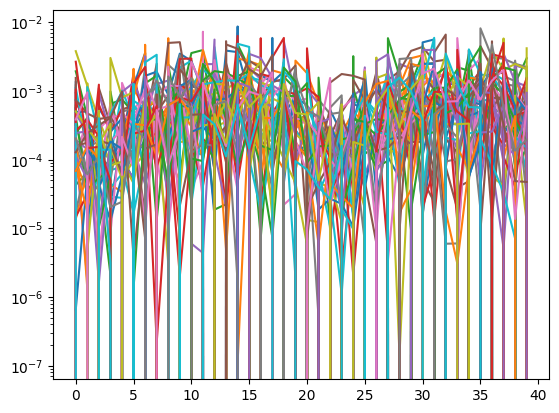

In [9]:
error = jit(lambda t,index : np.abs(opc[t+1][index] - visualstate(R[t], θ[t], index)))
fig,ax = plt.subplots()
for i in range(100):
    e = error(time, i)
    if np.max(e) > 5e-2:
        print(f"i = {i:3d}, err = {np.max(e):.0e}")
    ax.plot(e)
ax.semilogy();

In [10]:
visualstate(R[time], θ[time], 5)

Array([0.        , 0.        , 0.        , 0.        , 0.09840737,
       0.56699454, 0.11711771, 0.75985706, 1.        , 0.89458959,
       0.74554409, 0.90283636, 0.97298369, 1.        , 0.75763269,
       0.47251365, 0.68082128, 0.57210531, 0.35419087, 0.78506037,
       0.35014806, 1.        , 0.46555397, 0.85340577, 0.82906541,
       1.        , 1.        , 1.        , 0.95601915, 0.99503242,
       1.        , 0.5162504 , 0.72361204, 1.        , 1.        ,
       1.        , 0.14563015, 0.        , 0.        , 0.        ],      dtype=float64)

In [11]:
%timeit visualstate(R[time], θ[time], 5)

231 µs ± 979 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
%timeit mvisualstate(R[time], θ[time], np.arange(100))

16.1 ms ± 232 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
visualstate(R[10], θ[10], 1)

Array([0.90030336, 1.        , 1.        , 1.        , 1.        ,
       0.41528928, 0.        , 0.        , 0.77128032, 0.31923417,
       0.        , 0.31641163, 1.        , 0.0427316 , 0.89679115,
       0.81985322, 0.23664896, 0.        , 0.        , 0.        ,
       0.        , 0.08865779, 0.97057883, 0.46850008, 0.38176679,
       0.74235075, 0.91698928, 1.        , 0.70661237, 0.35788277,
       0.56719086, 0.93144995, 0.49723924, 0.73128363, 0.90345254,
       0.84200484, 0.60417493, 0.97894393, 0.92357617, 0.67426359],      dtype=float64)